## Riddler Classic

From Max Weinreich, a purge puzzle:

A town of 1,000 households has a strange law intended to prevent wealth-hoarding. On January 1 of every year, each household robs one other household, selected at random, moving all of that house’s money into their own house. The order in which the robberies take place is also random and is determined by a lottery. (Note that if House A robs House B first, and then C robs A, the houses of A and B would each be empty and C would have acquired the resources of both A and B.)

Two questions about this fateful day:

1. What is the probability that a house is not robbed over the course of the day?
2. Suppose that every house has the same amount of cash to begin with — say $100. Which position in the lottery has the most expected cash at the end of the day, and what is that amount?

### Part one

Each time one household randomly selects another household, there is a 998 in 999 chance that any given household *won't* be selected as the target. We assume, of course, a household cannot rob itself. Given that there are 1000 robberies on January 1, each household must escape being robbed 999 times in order to make it through the whole day without being robbed. Thus:


\begin{align}
P(\text{not robbed}) = \left(\frac{998}{999}\right)^{999} = 0.3677
\end{align}

### Part two


#### Defining Classes
I'll run a Monte Carlo simulation to explore how rank in the order of robberies affects a household's chances of gaining or losing wealth by the end of the day. First, I'll define some classes and methods.

In [1]:
%matplotlib notebook

import random
import pandas as pd

class Villager:
    
    def __init__(self, name):
        self.name = name
        self.robbed = False
        self.wealth = 100
        self.rank = None
        
    def acquire_target(self, population):
        '''Assigns the name of the Villager to be robbed'''
        potential_targets = range(population)
        del potential_targets[self.name] # Can't rob yourself!
        self.target = random.choice(potential_targets)
        return self.target
                
    def rob_target(self, target):
        '''Add the target's wealth to self's wealth. Then set
        target's wealth to zero
        
        :param target: Villager
        '''
        target.robbed = True
        self.wealth = self.wealth + target.wealth
        target.wealth = 0

class Village:
    
    def __init__(self, population):
        self.villagers = []
        for i in range(0, population):
            self.population = population
            new_villager = Villager(i)
            self.villagers.append(new_villager)
            
    def run_robbery_lottery(self):
        '''Set the village robbery order'''
        order = random.sample(range(self.population), self.population)
        self.robbery_order = order
        
    def redistribute(self):
        '''Run a trial of robberies'''
        self.run_robbery_lottery()
        for rank, place in enumerate(self.robbery_order):
            
            robbing_villager = self.villagers[place]
            robbing_villager.rank = rank
            
            robbed_villager_name = robbing_villager.acquire_target(self.population)
            robbed_villager = self.villagers[robbing_villager.target]
            robbing_villager.rob_target(robbed_villager)
              
    def all_results(self):
        '''Return the results from the village's day of pillaging.
        
        :return report: DataFrame
        '''
        report = []
        for villager in self.villagers:
            row = {}
            row['wealth'] = villager.wealth
            row['rank'] = villager.rank
            report.append(row)
        return pd.DataFrame(report)
     
class Simulation:
    
    def __init__(self, population):
        self.population = population
        self.sim_results = pd.DataFrame()
    
    def trial(self, trial_num):
        village = Village(self.population)
        village.redistribute()
        trial_results = village.all_results()
        self.sim_results = self.sim_results.append(trial_results)
        
    def run(self,num_trials):
        '''Run the simulation, then group the trial results
        by rank, averaging wealth.
        '''
        
        for trial in range(num_trials):
            if trial % 1000 == 0: 
                print "On trial " + str(trial)
            self.trial(trial)
        agg_results = self.sim_results[['rank','wealth']].groupby('rank').mean()
        return agg_results                

#### Running the simulation

Now, I'll create simulation for a village of 1000. Then, I'll run it 10000 times.

In [2]:
sim = Simulation(1000)
results = sim.run(10000)

On trial 0
On trial 1000
On trial 2000
On trial 3000
On trial 4000
On trial 5000
On trial 6000
On trial 7000
On trial 8000
On trial 9000


Let's plot rank against wealth.

<IPython.core.display.Javascript object>


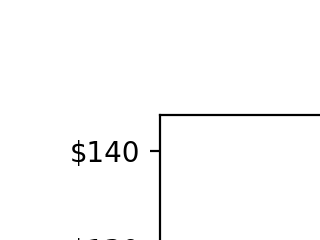

(0, 1000)

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure()
ax = plt.gca()

results.plot(ax=ax)
ax.set_title('538 Village of Thieves,\nExpected Cash, by Lottery Rank')

ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.0f'))
ax.legend_.remove()
plt.xlim([0,1000])

In [37]:
plt.savefig('village_of_theives.png')

Despite some noise, we can see that households that rob later in the day have higher expected loot. This makes intuitive sense, since household that rob late in the day have a better chance of holding onto their loot. Robbing last is best.

But what's the expected loot of robbing household number 1000? Our simulation gives only an approximate answer, with noise obscuring the fact that the last household has the highest expected earnings.

In [4]:
results.sort_values(by='wealth', ascending=False).head(15)

,wealth
rank,
998,140.27
979,138.02
997,137.92
996,137.56
977,137.19
986,137.09
992,136.63
999,136.51
995,136.41


I could try optimizing code to speed up the simulation, then include more trials within the simulation to reduce noise. But there's probably a better, analytical approach.

The last household's expected retained wealth is **`$`36.77**, since there's a **36.77`%`** chance that they keep the **`$`100** they started with. Their expected gained wealth is **`$`100**. The money has shifted over the course of previous robberies, but the overall pool of money remains unchanged. So, in total, their expected wealth at the end of the day is **`$`136.77**, which roughly matches the simuated results.



For fun, let's also see the expected distribution of wealth by the end of the day.

<IPython.core.display.Javascript object>


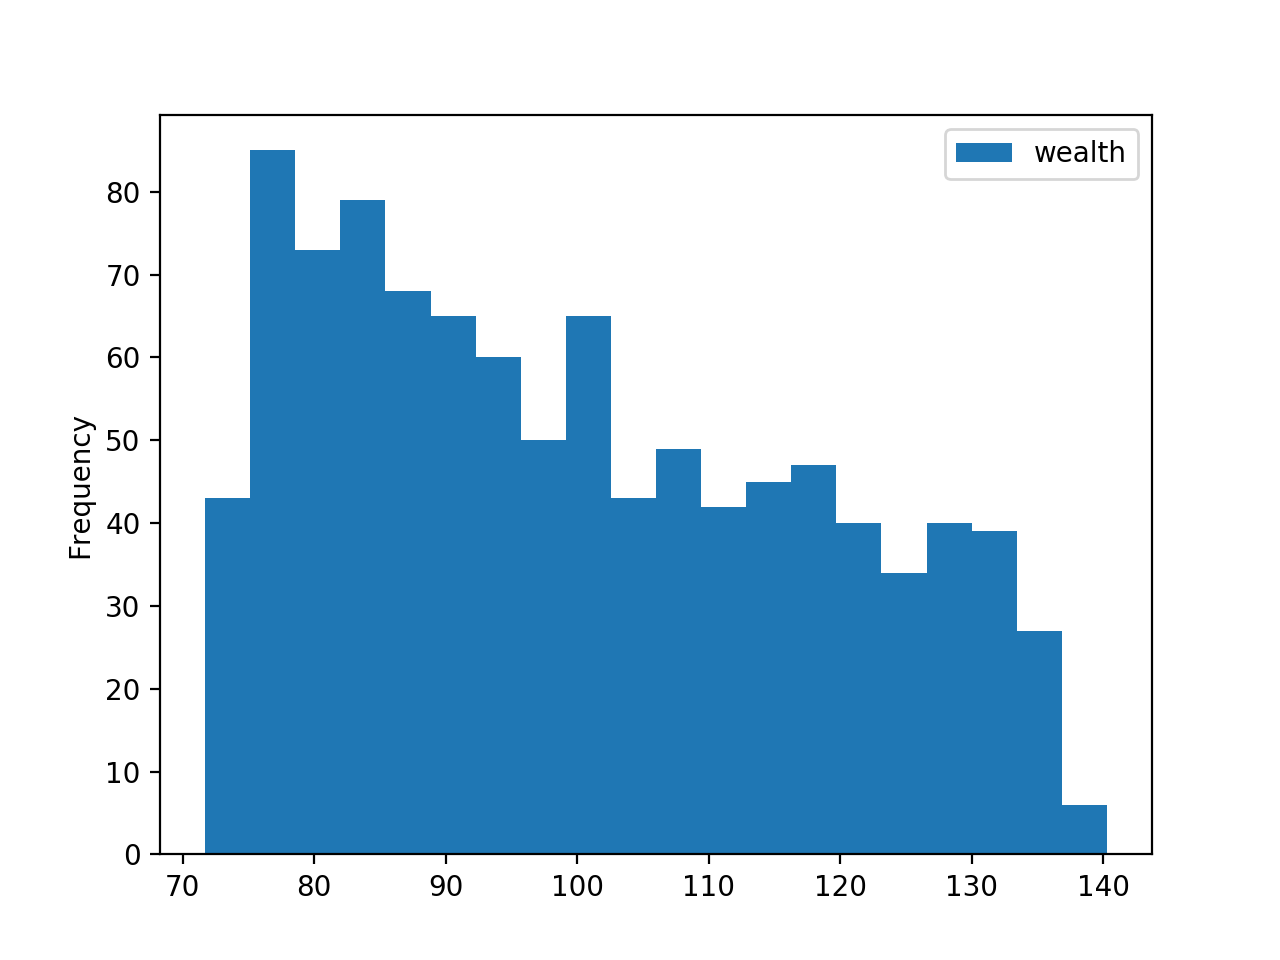

In [5]:
results.plot(kind='hist',bins=20)

The village's system of income redistribution increases wealth inequality, when starting with complete wealth equality. It would be interesting to see how the system plays out over the course of multiple years.